In [1]:
%load_ext jupyter_black

In [3]:
!pip install seaborn

# scikit-learn 

Главная библиотека для классического ML. Сегодня ознакомимся с основным пайплайном на примере задачи бинарной классификации табличных данных.

В sklearn есть очень качественный, проиллюстрированный кодом [мануал](https://scikit-learn.org/stable/index.html), который способен заменить учебник по "ML для практиков".

## Бинарная классификация
Датасет состоит из пар $(x,y)$, где $y$ - "правильный класс". **Бинарная** классификация - это когда у $y$ всего два значения, кодируемые как 0 или 1.

**N.B.** Часто в подобных ситуациях это "присутствие" или "отсутсвие" какого-то признака. Такая формулировка не влияет на суть происходящего, но позволяет лучше понять мотивацию некоторых концептов ниже. А еще она нужно, конгда мы будем обобщать штуки из сегодняшнего урока на случай нескольких классов. Одна из основных идей - относиться к проблеме классификации с $K$ классами как $K$ задачам бинарной: предсказываем (конкретный класс) vs (остальные).


Про датасет мы предполагаем что $x$ - фиксированы (они будут всегда появляться только справа от черты во всех условных вероятностях), а $y$ - независимо порождены из некоторого *истинного* распределения $P(y|x)$.

## Метрики классификации

Начнем с того, что научимся оценивать уже имеющиеся предсказания, то есть оценка $\hat P(y|x)$. 

In [4]:
%matplotlib inline
import pandas as pd

df = pd.DataFrame(
    {
        "id": list(range(1, 8)),
        "score": [
            0.5,
            0.1,
            0.2,
            0.6,
            0.2,
            0.3,
            0.0,
        ],  # так обычно выглядит выход из бинарного классификатора
        "class": [0, 0, 0, 1, 1, 1, 0],  # "правильные" метки
    }
)

df.head(7)

,id,score,class
0,1,0.5,0
1,2,0.1,0
2,3,0.2,0
3,4,0.6,1
4,5,0.2,1
5,6,0.3,1
6,7,0.0,0


## TP, TN, FP, FN, confusion matrix

В бинарной классификации для каждого наблюдаемого бывает всего 4 ситуации, и у каждой свое название. Похоже, что это пришло из Statistical hypothesis testing, где есть "нулевая гипотеза" (верная или неверная) и результат статистического теста (отвергнуть гипотезу, или принять).


True Positive - предсказано 1, метка -- 1

True Negative - предсказано 0, метка -- 0

False Positive (a.k.a ошибка первого рода) - предсказано 1, метка -- 0 

False Negative (a.k.a ошибка второго рода) - предсказано 0, метка -- 1

## Через эти ошибки можно выразиьт целое семейство метрик бинарной классификации:

**Accuracy** -- доля верно классифицированных точек данных

**Recall** -- доля точек данных предсказанного первого класса среди истинного первого класса

**Precision** -- наоборот, доля точек данных, которые принадлежат истинному первому классу среди тех, что модель отнесла к нему

**F1-score** -- среднее гармоническое точности и полноты

Упражнение: выразить через TP, TN, FP, FN.

accuracy = (TP+TN)/(TP + FN + FP + TN)

recall = (TP)/(TP + FN)

precision = (TP)/(TP + FP)

f1 = 2 * Precision * Recall / (Precision + Recall)

#### One-vs-Rest
Представим на секунду, что у нас не два класса, а, скажем, N. 

Как мне обобщить полученные метрики на этот случай?

* macro averaging

* weighted averaging

* micro averaging

### Confusion matrix

<Axes: >

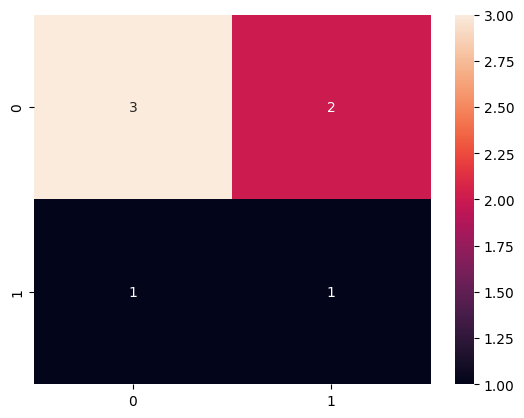

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# это уже не только для бинарной классификации, можно построить confusion matrix для любого числа классов
sns.heatmap(
    confusion_matrix(df["score"] >= 0.5, df["class"]),  # а почему 0.5?
    annot=True,
    fmt="g",
)

Конечно, все метрики уже есть в библиотеке. Давайте проверим ваши формулы.

In [5]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

df[">2"] = df["score"].map(lambda x: 1 if x >= 0.2 else 0)
df  # .drop("score", axis=1)

,id,score,class,>2
0,1,0.5,0,1
1,2,0.1,0,0
2,3,0.2,0,1
3,4,0.6,1,1
4,5,0.2,1,1
5,6,0.3,1,1
6,7,0.0,0,0


In [13]:
TP = df[(df["class"] == 1) & (df[">2"] == 1)].count()["id"]
FN = df[(df["class"] == 1) & (df[">2"] == 0)].count()["id"]
FP = df[(df["class"] == 0) & (df[">2"] == 1)].count()["id"]
TN = df[(df["class"] == 0) & (df[">2"] == 0)].count()["id"]
TP, TN, FP, FN

(np.int64(3), np.int64(2), np.int64(2), np.int64(0))

In [6]:
precision = ...
assert precision == precision_score(df["class"], df[">2"])

In [7]:
recall = ...
assert recall == recall_score(df["class"], df[">2"])

In [8]:
accuracy = ...
assert accuracy == accuracy_score(df["class"], df[">2"])

In [9]:
f1 = ...
assert f1 == f1_score(df["class"], df[">2"])
# assert (f1 - f1_score(df["class"], df[">2"])) ** 2 < 1e-8

AssertionError: 

# ROC-AUC

Это все здорово, но две проблемы: 
1. Как выбрать порог для бинаризации.  $0.5$ - очень разумная мысль, если верить что предсказания модели являются вероятностями. Но обычно скоры модели - это **совсем не вероятности**, даже если это числа из $[0,1]$, суммирующиеся в единицу! Настоящие вероятности - это когда среди примеров со скором "примерно 0.8", примерно 80% действительно принадлежат к этому классу. Но в жизни такое случается редко, и применяются специальные техники калибровки вероятностей, о которых мы поговорим позднее.
2. Описанные метрики никак не учитывают абсолютное значение скоров. Модель, которая оценивает вероятности в $50 \pm \varepsilon \%$ получает столько же, сколько модель которая "уверена" в своих ответах.


И тут на сцену выходит ROC-AUC. 

* ROC: Reciever Operating Characteristic - кривая соотношения TP/FP в зависимости от порога. Называется так, потому что впервые ее использовали американские военные во время WWII для оценки качества радаров
* AUC: Area Under Curve

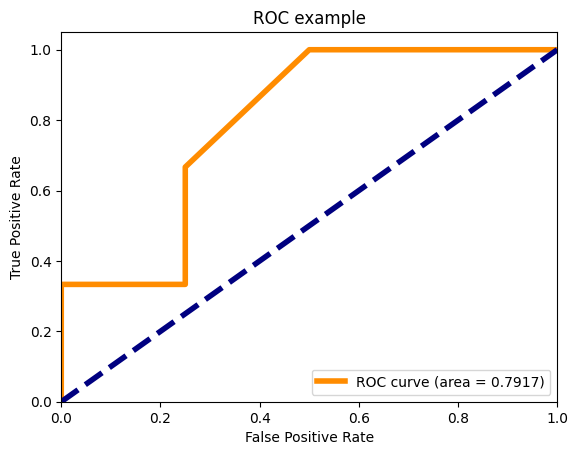

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df["class"], df["score"])
roc_auc = roc_auc_score(df["class"], df["score"])

import matplotlib.pyplot as plt

plt.figure()
lw = 4  # line width

plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.4f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC example")
plt.legend(loc="lower right")

plt.show()

In [11]:
for t in list(thresholds):
    TP = df[(df["score"] >= t) & (df["class"] == 1)]["id"].count()
    TN = df[(df["score"] < t) & (df["class"] == 0)]["id"].count()
    FP = df[(df["score"] >= t) & (df["class"] == 0)]["id"].count()
    FN = df[(df["score"] < t) & (df["class"] == 1)]["id"].count()
    TP_rate = TP / (TP + FN)
    FP_rate = FP / (TN + FP)
    print(f" Threshold: {t} TP Rate: {TP_rate:6f} FP Rate: {FP_rate}")

 Threshold: inf TP Rate: 0.000000 FP Rate: 0.0
 Threshold: 0.6 TP Rate: 0.333333 FP Rate: 0.0
 Threshold: 0.5 TP Rate: 0.333333 FP Rate: 0.25
 Threshold: 0.3 TP Rate: 0.666667 FP Rate: 0.25
 Threshold: 0.2 TP Rate: 1.000000 FP Rate: 0.5
 Threshold: 0.0 TP Rate: 1.000000 FP Rate: 1.0


In [12]:
tpr, fpr

(array([0.        , 0.33333333, 0.33333333, 0.66666667, 1.        ,
        1.        ]),
 array([0.  , 0.  , 0.25, 0.25, 0.5 , 1.  ]))

Но вообще есть `plot_roc_curve` и вот такое

/home/arabella/Downloads/sync/work/teaching/teaching_venv/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


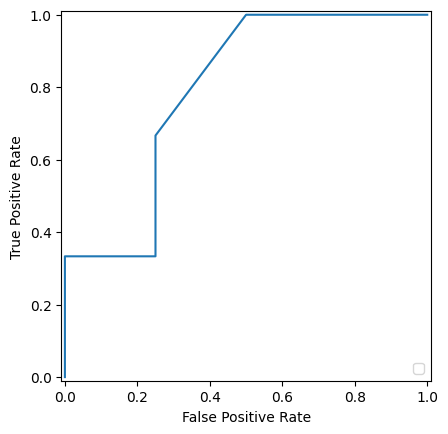

In [13]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

#### Кстати, покажите что ROC-кривая монотонна для любых данных и моделей.

...

### Precision-Recall curve

Другая кривая, в которой изменяется соотношение Precision к Recall.

Упражнение: обязательно ли эта кривая будет монотонной?

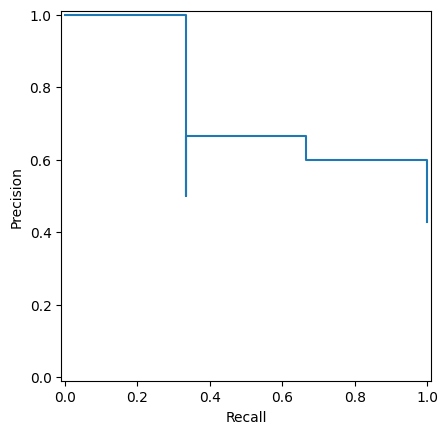

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(df["class"], df["score"])

precision, recall, thresholds

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

Метрика, суммаризующая эту кривую, называется **Average Precision (AP)**. Кстати, это очень популярная метрика в задачах сегментации изображений и object detection.

Формально, здесь вообще не будет тресхолда: поскольоку recall монотонен по тресхолду, можнго думать про эту кривую как про функцию Precision(recall). $$AP = \int\limits_0^1 Precision(r)dr = \int\limits_0^1 Precision(t)\frac{\partial Recall(t)}{\partial t} dt$$


**Упражнение.** 
* Какова worst-case сложность подсчета этой метрики наивно(т е варьируем тресхолд, считаем Precision, Recall и потом усредняем)?
* А как посчитать за $O(N \log N)$, где N-число точек данных?

# И ещё раз, без спешки

Самое крупное кораблекрушение Европы в мирное время, в предполагаемых причинах которого до сих пор нет окончательной уверенности.

```
«Estonia» (ранее «Viking Sally», «Silja Star», «Wasa King») — 
эстонский паром судоходной компании «Estline», построенный 
в 1979 году в ФРГ на судоверфи «Meyer Werft» в Папенбурге. 
Затонул в Балтийском море в ночь с 27 на 28 сентября 1994 года, 
в результате крушения пропали без вести 757 человек и 
погибли 95 человек (всего 852) из 989 находившихся 
на борту пассажиров и членов экипажа. Это крупнейшее 
в Европе кораблекрушение в мирное время. 
```

Датасет можно скачать [тут](https://www.kaggle.com/datasets/christianlillelund/passenger-list-for-the-estonia-ferry-disaster)

In [ ]:
import pandas as pd

all_data = pd.read_csv("data/estonia-passenger-list.csv")
all_data.head(2)

In [ ]:
all_data["Country"].value_counts()

In [ ]:
anonymized_data = all_data.drop(["Firstname", "Lastname", "PassengerId"], axis=1)
anonymized_data.head(1)

In [ ]:
y = anonymized_data["Survived"]
y.value_counts()

In [ ]:
anonymized_data[anonymized_data['Country'] == 'Belarus']

In [ ]:
import seaborn as sns

# нарисуем среднюю выживаемость и дисперсию
sns.barplot(x='Country',y='Survived', data=anonymized_data)

# Поворот  подписей
plt.xticks(rotation=70)
plt.tight_layout()

In [ ]:
# Зависит ли выживаемость от категории Пассажиры/Passengers; Команда/Сrew 
sns.barplot(x='Category', y='Survived', data=anonymized_data)

In [ ]:
anonymized_data["Category"].value_counts()

А как распределён возраст?

Можно посмотреть встроенными средствами pandas:

In [ ]:
anonymized_data["Age"].hist()

# Подготовка данных

#### Dummy-coding AKA One-Hot-Encoding

Но чаще всё-таки удобнее кодировать средствами sklearn, увидим ниже.

In [ ]:
countries = pd.get_dummies(anonymized_data["Country"], prefix="c")
countries

Сами разобьём на обучающую и тестовую выборки -- до всех предобработок, это важно!

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

data_train, data_test, y_train, y_test = train_test_split(
                                                    anonymized_data.drop(["Survived"], axis=1), # X
                                                    anonymized_data["Survived"], # y
                                                    test_size=0.3, # доля от всех записей
                                                    random_state=1337, # зерно
                                                    stratify=anonymized_data["Survived"], # а это что?
                                        )

# print(data_train.shape, y_train.shape, data_test.shape, y_test.shape)

# np.sum(y_train) / y_train.shape[0], np.sum(y_test) / y_test.shape[0]
# nonames_data.shape, data_train.shape
# y_train, y_test
# y_train.value_counts()

In [ ]:
data_train.head(2)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy import sparse as sp

# Не все классификаторы умеют обращаться с категориальными признаками. 
def prepare_features_for_logreg(data: pd.DataFrame, cat_encoder=None, real_scaler=None):
    cat_columns = ["Country", "Sex", "Category"]  
    real_columns = ["Age"]
    
    # categorical features
    if cat_encoder is None:
        ohe = OneHotEncoder(handle_unknown="ignore")
        ohe.fit(data[cat_columns])
    else:
        ohe = cat_encoder
    X_cat = ohe.transform(data[cat_columns])
    cat_fnames = ohe.get_feature_names_out(cat_columns)
    
    # real-valued features
    if real_scaler is None:
        stsc = StandardScaler()
        stsc.fit(data[real_columns])
    else:
        stsc = real_scaler
    X_real = stsc.transform(data[real_columns])
    feature_matrix = sp.hstack([X_cat, X_real])
    
    return feature_matrix, list(cat_fnames) + real_columns, ohe, stsc

X_train_sparse, fnames_sparse, encoder_sparse, scaler = prepare_features_for_logreg(data_train)
X_test_sparse, _, _, _ = prepare_features_for_logreg(data_test, encoder_sparse, scaler)

X_train_sparse.shape, X_test_sparse.shape
# X_train_sparse.todense()
# X_test_sparse.todense()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

clf_linear = LogisticRegression(C=0.99, class_weight="balanced", 
                                solver="saga", penalty="l1")
clf_linear.fit(X_train_sparse, y_train)

y_pred = clf_linear.predict(X_test_sparse)

print(classification_report(y_test, y_pred))
# clf_linear.coef_

In [ ]:
y_pred, y_test

sns.heatmap(confusion_matrix(
    y_pred,
    y_test
),annot=True, fmt='g')

Хороший способ проверить, не ерунду ли мы сделали: внимание на **accuracy** и на метрики в разделе **macro-averaged**

In [ ]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(strategy="most_frequent").fit(X_train_sparse, y_train)
y_pred = clf_dummy.predict(X_test_sparse)

print(classification_report(y_test, y_pred))

Подготовим признаки для логических классификаторов -- там обычно можно без разреженных признаков и нормализации

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from scipy import sparse as sp

def prepare_features_for_logic(data: pd.DataFrame, cat_encoder=None):
    
    cat_columns = ["Country", "Sex", "Category"]  
    real_columns = ["Age"]
    
    # categorical features
    if cat_encoder is None:
        oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        oe.fit(data[cat_columns])
    else:
        oe = cat_encoder
    
    X_cat = oe.transform(data[cat_columns])
    mapped_cat_values = oe.categories_
    cat_fnames = cat_columns
    
    # real-valued features
    
    # todo: вообще очень часто есть смысл отбросить из обучающей выборки примеры, 
    #       значения которых редки (например, выпадающие далеко "за три сигмы")
    
    X_real = data[real_columns].values    
    feature_matrix = np.hstack([X_cat, X_real]) # note: `np` for dense Numpy matrices
    
    return feature_matrix, list(cat_fnames) + real_columns, oe, mapped_cat_values

X_train_dense, fnames_dense, encoder, mapped_cat_values = prepare_features_for_logic(data_train)
X_test_dense, _, _, _ = prepare_features_for_logic(data_test, encoder)


X_train_dense.shape, X_test_dense.shape

mapped_cat_values
X_train_dense

In [ ]:
data_train.head(0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2, class_weight="balanced").fit(X_train_dense, y_train)
y_pred = clf.predict(X_test_dense)

print(classification_report(y_test, y_pred))

In [ ]:
sum(clf.feature_importances_)

Но пока мы даже не попытались настроить модели, результаты ничего не значат.

Кстати, смотрите, как можно.


In [ ]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)


plot_tree(clf, feature_names=fnames_dense, class_names=["Dead", "Surv"], proportion=True)

--- 

# Познакомились с minimum minimorum, поперебираем
попробуем получить результаты получше со случайным лесом

Посмотрим на самые важные параметры.

```
class sklearn.ensemble.RandomForestClassifier(

                        n_estimators=100,  
                            Число деревьев.              
                            
                        criterion='gini', 
                            Критерий: индекс Джини либо энтропия, может зависеть от вида дерева
                            
                        max_depth=None, 
                            Самая, пожалуй, естественная регуляризация -- ограничение глубины дерева
                            
                        min_samples_split=2,
                            Сколько должно попасть в вершину объектов, чтобы её можно было ветвить дальше
                            
                        min_samples_leaf=1, 
                            Очень мощный и важный регуляризатор! Сколько минимум объектов должно быть в листе
                            
                        max_features='auto', 
                            Среди какого числа признаков выбираем очередное ветвление
                            
                        max_leaf_nodes=None, 
                            Хороший регуляризатор -- ограничение на количество листьев; добавляются по убыванию
                            снижения impurity.
                            
                        min_impurity_decrease=0.0, 
                            Порог по уменьшению impurity, который запрещает ветвить дерево дальше.
                        
                        bootstrap=True, 
                            Если False, обучаем каждое дерево на всём наборе данных. 
                            Если True, только на части, размер которой задан в max_samples.
                            
                        n_jobs=None, 
                            На сколько job-ов распараллелить.
                            
                        random_state=None, 
                            Ну, тут всё понятно: случайный seed, позволяющий воспроизводить результаты.
                        
                        verbose=0, 
                            Степень подробности протоколирования хода обучения и всего такого. Обычно 0,1,2.
                            
                        warm_start=False, 
                            Это такая возможность переиспользовать обученный ансамбль для последующих задач.
                             
                        max_samples=None
                            Сколько максимум сэмплов брать из датасета для обучения очередного дерева, если bootstrap
                        )
```

In [ ]:
param_grid = {
    "n_estimators": [10, 50, 100],
    "min_samples_leaf": [1, 2, 3, 5],
    "max_samples": [0.3, None],
    "class_weight" : ["balanced", "balanced_subsample"]
}
param_grid

In [ ]:
y_train.shape, y_test.shape, type(y_train)

### Упражнение
Зачем нужен KFold? Почему нельзя просто считать метрики на тесте?


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = StratifiedKFold(n_splits=3, random_state=100, shuffle=True)

print(y_train.values.mean())

for array1, array2 in kfold.split(X_train_dense, y_train):   
    x_train_cv = X_train_dense[array1]
    y_train_cv = np.array(y_train)[list(array1)]
    
    x_test_cv = X_train_dense[array2]
    y_test_cv = np.array(y_train)[list(array2)]
    
    print(y_train_cv.mean(), y_test_cv.mean())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

scores = ["accuracy"]

for score in scores:
    print("# Tuning for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=100), 
                       param_grid, scoring=score, verbose=1, cv=3)

    clf.fit(X_train_dense, y_train)

    print("Best params on dev set:")
    print(clf.best_params_)
    
    print("Scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    best_model = clf.best_estimator_
    best_model.fit(X_train_dense, y_train)

    y_true, y_pred = y_test, best_model.predict(X_test_dense)
    
    print(classification_report(y_true, y_pred))
    print()

---
## Укладываем вообще всё в один пайплайн
---
Результаты вряд ли будут впечатляющими, но на этом примере посмотрим, как можно удобно запрограммировать перебор параметров не только классификации.

Понизим размерность и применим KNN.

Вариантов понижения размерности [много](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition). Возьмём самый стандартный и работающий с разреженными признаками.

In [ ]:
from sklearn.decomposition import TruncatedSVD

decomposer = TruncatedSVD(n_components=6, random_state=10, n_iter=200)
X_train_svd = decomposer.fit_transform(X_train_sparse)
X_test_svd = decomposer.transform(X_test_sparse)

X_train_svd.shape, X_test_svd.shape, X_train_sparse.shape, X_train_svd

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)

In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('svd', decomposer), 
                       ('knn', knn)])

In [ ]:
param_grid = [
    {
        "svd__n_components": [2, 4, 6, 10],
        "svd__n_iter": [5, 100, 1000],
        "knn__n_neighbors": [1, 2, 3, 4, 5],
        "knn__weights" : ["uniform", "distance"],
        "knn__metric" : ["euclidean"]
    }
]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
scores = ["f1_macro"]#, "accuracy"]

for score in tqdm(scores):
    print("# Tuning for %s" % score)
    print()
    
    clf = GridSearchCV(pipe, param_grid, scoring=score, verbose=2, cv=3)
    clf.fit(X_train_sparse, y_train)

    print("Best params on dev set:")
    print(clf.best_params_)
    
    print("Scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    best_model = clf.best_estimator_
    best_model.fit(X_train_sparse, y_train)

    y_true, y_pred = y_test, best_model.predict(X_test_sparse)
    
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
clf.best_estimator_

# Задача 5. Паром.

Получите accuracy > 0.89 на тестовом датасете. Можно пользоваться любым классификатором **из sklearn**. Ансамблями пользоваться можно.

### XtreemeGradientBoosting и нейронные сети запрещены. 

# Задача 6. Линрег

Допустим, у вас есть два множества **A** и **B** точек на плоскости. Линейная регрессия на плоскости -- это 
просто прямая, ее можно представить как функцию $ y = ax + b$.

Линейная регрессия, обученная на множестве **А**, имеет коэффициент **$a > 0$**. То же самое верно и для линейной регрессии, обученной на множестве **B**. Правда ли, что если обучить линейную регрессию на множестве $A \cup B$, то у полученной прямой коэффициент **a** будет больше 0?

Если да -  докажите, если нет - постройте контрпример.